In [1]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import Dataset
import pandas as pd
import keras

C:\Users\Shaun\anaconda3\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
C:\Users\Shaun\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
#!pip uninstall transformers
!pip install --upgrade transformers
!pip install --upgrade torch
!pip install --upgrade tensorflow
!pip install --upgrade tokenizers
!pip install --upgrade huggingface-hub
!pip install --upgrade sentencepiece


  Using cached tokenizers-0.19.1-cp39-none-win_amd64.whl.metadata (6.9 kB)
Using cached tokenizers-0.19.1-cp39-none-win_amd64.whl (2.2 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.0
    Uninstalling tokenizers-0.20.0:
      Successfully uninstalled tokenizers-0.20.0
   ---------------------------------------- 0.0/199.3 MB ? eta -:--:--
   - -------------------------------------- 5.2/199.3 MB 26.5 MB/s eta 0:00:08
   -- ------------------------------------- 11.0/199.3 MB 28.7 MB/s eta 0:00:07
   --- ------------------------------------ 17.0/199.3 MB 27.5 MB/s eta 0:00:07
   ---- ----------------------------------- 22.3/199.3 MB 26.6 MB/s eta 0:00:07
   ----- ---------------------------------- 27.0/199.3 MB 25.5 MB/s eta 0:00:07
   ------ --------------------------------- 30.4/199.3 MB 24.1 MB/s eta 0:00:08
   ------ --------------------------------- 34.1/199.3 MB 23.0 MB/s eta 0:00:08
   ------- -------------------------------- 37.7/199.3 MB 22

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.4.0 requires torch==2.4.0, but you have torch 2.4.1 which is incompatible.
torchvision 0.19.0 requires torch==2.4.0, but you have torch 2.4.1 which is incompatible.


   ---------------------------------------- 0.0/385.0 MB ? eta -:--:--
   ---------------------------------------- 4.2/385.0 MB 22.9 MB/s eta 0:00:17
   - -------------------------------------- 9.7/385.0 MB 24.1 MB/s eta 0:00:16
   - -------------------------------------- 13.6/385.0 MB 22.5 MB/s eta 0:00:17
   - -------------------------------------- 17.8/385.0 MB 21.6 MB/s eta 0:00:17
   -- ------------------------------------- 21.5/385.0 MB 20.6 MB/s eta 0:00:18
   -- ------------------------------------- 24.1/385.0 MB 19.1 MB/s eta 0:00:19
   -- ------------------------------------- 26.7/385.0 MB 18.2 MB/s eta 0:00:20
   --- ------------------------------------ 29.4/385.0 MB 17.6 MB/s eta 0:00:21
   --- ------------------------------------ 32.5/385.0 MB 17.2 MB/s eta 0:00:21
   --- ------------------------------------ 35.7/385.0 MB 16.9 MB/s eta 0:00:21
   ---- ----------------------------------- 38.8/385.0 MB 16.7 MB/s eta 0:00:21
   ---- ----------------------------------- 41.4/38

  You can safely remove it manually.
  You can safely remove it manually.


  Using cached tokenizers-0.20.0-cp39-none-win_amd64.whl.metadata (6.9 kB)
Using cached tokenizers-0.20.0-cp39-none-win_amd64.whl (2.3 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.44.2 requires tokenizers<0.20,>=0.19, but you have tokenizers 0.20.0 which is incompatible.


In [42]:
df23= pd.read_csv('twitter_dataset_2023.csv')

In [43]:
df23.head()

,Unnamed: 0,Tweet_ID,Text,Retweets,Likes,Timestamp,Sentiment,Score
0,0,1,party least receive say single prevent prevent...,2,25,2023-01-30 11:00:51,Neutral,0.805038
1,1,2,hotel still congress may member staff medium d...,35,29,2023-01-02 22:45:58,Neutral,0.926011
2,2,3,nice debate industry year film generation push...,51,25,2023-01-18 11:25:19,Positive,0.873134
3,3,4,laugh explain situation career occur serious f...,37,18,2023-04-10 22:06:29,Neutral,0.833324
4,4,5,involve sense former often approach government...,27,80,2023-01-24 07:12:21,Neutral,0.879556


In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# Set stop words to English
stop_words = set(stopwords.words('english'))
# Add 'rt' to remove retweet indicator in dataset (noise)
stop_words.add("rt")
stop_words.add("user")

# Remove HTML entities from tweets
def remove_html(raw_tweet):
    entity_regex = r"&[^\s;]+;"
    tweet = re.sub(entity_regex, "", raw_tweet)
    return tweet

# Change the usernames to 'user'
def change_username(raw_tweet):
    regex = r"@([^\s]+)"
    tweet = re.sub(regex, "user", raw_tweet)
    return tweet

# Remove URLs
def remove_url(raw_tweet):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    tweet = re.sub(url_regex, '', raw_tweet)
    return tweet

# Remove noisy symbols
def remove_symbols(raw_tweet):
    tweet = re.sub(r'[\"#:?\'@*!`,._()-]', '', raw_tweet)
    return tweet

# Spell checker
def spellcheck(raw_tweet):
    spell = Speller(lang='en')
    tweet = spell(raw_tweet)
    return tweet

# Remove stopwords and lemmatize
from nltk.corpus import wordnet
def remove_stopwords_and_lemmatize(raw_tweet):
    tweet = raw_tweet.lower()
    tokens = nltk.word_tokenize(tweet)
    lemmatizer = WordNetLemmatizer()
    tweet = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    tweet= " ".join(tweet) #use to return tweets to sentence
    return tweet

# Function to clean all tweets by utilizing the above functions
def preprocess(data):
    clean = []
    for tweet in data:
        tweet = change_username(tweet)
        tweet = remove_html(tweet)
        tweet = remove_url(tweet)
        tweet = remove_symbols(tweet)
        #tweet = spellcheck(tweet)
        tweet = remove_stopwords_and_lemmatize(tweet)
        clean.append(tweet)
    return clean


In [7]:
tweet_list = list(df23['Text'])
# Run the preprocessing function
clean_tweet = preprocess(tweet_list)
df23['Text']= clean_tweet


In [8]:
df23.head()

,Tweet_ID,Text,Retweets,Likes,Timestamp
0,1,party least receive say single prevent prevent...,2,25,2023-01-30 11:00:51
1,2,hotel still congress may member staff medium d...,35,29,2023-01-02 22:45:58
2,3,nice debate industry year film generation push...,51,25,2023-01-18 11:25:19
3,4,laugh explain situation career occur serious f...,37,18,2023-04-10 22:06:29
4,5,involve sense former often approach government...,27,80,2023-01-24 07:12:21


In [27]:
#Tweet sentiment model Using a pipeline
from transformers import pipeline
task='sentiment'
SentimentClassifierTweet = pipeline("text-classification", model=f"cardiffnlp/twitter-roberta-base-{task}")

C:\Users\Shaun\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
# Defining a function to call for the whole dataframe
def FunctionBERTSentimentTweet(inpText):
    result = SentimentClassifierTweet(inpText)[0]
    return result['label'], result['score']

# BERTTweet sentiment result function for every tweet
df23[['Sentiment', 'Score']] = df23['Text'].apply(lambda x: pd.Series(FunctionBERTSentimentTweet(x)))

# Displaying the first 10 rows
df23.head(10)

,Tweet_ID,Text,Retweets,Likes,Timestamp,Sentiment,Score
0,1,party least receive say single prevent prevent...,2,25,2023-01-30 11:00:51,LABEL_1,0.805038
1,2,hotel still congress may member staff medium d...,35,29,2023-01-02 22:45:58,LABEL_1,0.926011
2,3,nice debate industry year film generation push...,51,25,2023-01-18 11:25:19,LABEL_2,0.873134
3,4,laugh explain situation career occur serious f...,37,18,2023-04-10 22:06:29,LABEL_1,0.833324
4,5,involve sense former often approach government...,27,80,2023-01-24 07:12:21,LABEL_1,0.879556
5,6,cell without report weight could father change...,22,75,2023-03-30 09:56:07,LABEL_1,0.846128
6,7,receive difference responsibility build let de...,12,43,2023-01-02 03:15:54,LABEL_1,0.756050
7,8,five sort guy politics somebody pretty magazin...,0,12,2023-01-22 20:08:31,LABEL_1,0.896401
8,9,reveal table state view manager fly yeah daugh...,15,26,2023-03-24 15:17:03,LABEL_1,0.873683
9,10,list allow family rather continue agency messa...,97,28,2023-02-01 20:32:07,LABEL_1,0.815786


In [26]:
df23['Sentiment'].replace('LABEL_0', 'Negative', inplace=True) #Negative
df23['Sentiment'].replace('LABEL_1', 'Neutral', inplace=True) #Neutral
df23['Sentiment'].replace('LABEL_2', 'Positive', inplace=True) #Positive
# Displaying the first 10 rows
df23.head(10)

,Tweet_ID,Text,Retweets,Likes,Timestamp,Sentiment,Score
0,1,party least receive say single prevent prevent...,2,25,2023-01-30 11:00:51,Neutral,0.805038
1,2,hotel still congress may member staff medium d...,35,29,2023-01-02 22:45:58,Neutral,0.926011
2,3,nice debate industry year film generation push...,51,25,2023-01-18 11:25:19,Positive,0.873134
3,4,laugh explain situation career occur serious f...,37,18,2023-04-10 22:06:29,Neutral,0.833324
4,5,involve sense former often approach government...,27,80,2023-01-24 07:12:21,Neutral,0.879556
5,6,cell without report weight could father change...,22,75,2023-03-30 09:56:07,Neutral,0.846128
6,7,receive difference responsibility build let de...,12,43,2023-01-02 03:15:54,Neutral,0.756050
7,8,five sort guy politics somebody pretty magazin...,0,12,2023-01-22 20:08:31,Neutral,0.896401
8,9,reveal table state view manager fly yeah daugh...,15,26,2023-03-24 15:17:03,Neutral,0.873683
9,10,list allow family rather continue agency messa...,97,28,2023-02-01 20:32:07,Neutral,0.815786


In [27]:
df23.to_csv('twitter_dataset_2023.csv')

In [10]:
df23= pd.read_csv('twitter_dataset_2023.csv')

<AxesSubplot:xlabel='Score', ylabel='Sentiment'>

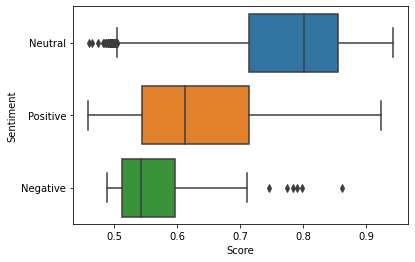

In [11]:
sns.boxplot(x='Score', y='Sentiment', hue=None, data=df23, whis=1.5, notch=False, ax=None)

## Classification Twitter 2023 

In [6]:
df23=pd.read_csv('twitter_dataset_2023.csv')
df23.head()

,Unnamed: 0,Tweet_ID,Text,Retweets,Likes,Timestamp,Sentiment,Score
0,0,1,party least receive say single prevent prevent...,2,25,2023-01-30 11:00:51,Neutral,0.805038
1,1,2,hotel still congress may member staff medium d...,35,29,2023-01-02 22:45:58,Neutral,0.926011
2,2,3,nice debate industry year film generation push...,51,25,2023-01-18 11:25:19,Positive,0.873134
3,3,4,laugh explain situation career occur serious f...,37,18,2023-04-10 22:06:29,Neutral,0.833324
4,4,5,involve sense former often approach government...,27,80,2023-01-24 07:12:21,Neutral,0.879556


In [13]:
# column 'Variable'
df23= pd.read_csv('classifiedtwitter_dataset_2023.csv')
df2023 = df23.groupby('Classification_Label').head(20).reset_index(drop=True)
df2023

,Unnamed: 0.1,Unnamed: 0,Tweet_ID,Text,Retweets,Likes,Timestamp,Sentiment,Score,Classification,Classification_Label
0,0,0,1,party least receive say single prevent prevent...,2,25,2023-01-30 11:00:51,Neutral,0.805038,2,Neither
1,1,1,2,hotel still congress may member staff medium d...,35,29,2023-01-02 22:45:58,Neutral,0.926011,2,Neither
2,2,2,3,nice debate industry year film generation push...,51,25,2023-01-18 11:25:19,Positive,0.873134,2,Neither
3,3,3,4,laugh explain situation career occur serious f...,37,18,2023-04-10 22:06:29,Neutral,0.833324,2,Neither
4,4,4,5,involve sense former often approach government...,27,80,2023-01-24 07:12:21,Neutral,0.879556,2,Neither
5,5,5,6,cell without report weight could father change...,22,75,2023-03-30 09:56:07,Neutral,0.846128,2,Neither
6,6,6,7,receive difference responsibility build let de...,12,43,2023-01-02 03:15:54,Neutral,0.756050,2,Neither
7,7,7,8,five sort guy politics somebody pretty magazin...,0,12,2023-01-22 20:08:31,Neutral,0.896401,2,Neither
8,8,8,9,reveal table state view manager fly yeah daugh...,15,26,2023-03-24 15:17:03,Neutral,0.873683,2,Neither
9,9,9,10,list allow family rather continue agency messa...,97,28,2023-02-01 20:32:07,Neutral,0.815786,2,Neither


In [20]:
df23.to_csv('classifiedtwitter_dataset_2023.csv')

In [16]:
from transformers import BertForSequenceClassification, BertTokenizer

# Define the path where the model and tokenizer were saved
model_save_path = 'bert-base-uncased'

# Load the trained model
model = BertForSequenceClassification.from_pretrained(model_save_path)

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

C:\Users\Shaun\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [19]:
import torch
import pandas as pd
from transformers import BertForSequenceClassification, BertTokenizer

# Function to classify a single tweet
def classify_tweet(tweet):
    # Tokenize the tweet and convert to tensor
    inputs = tokenizer(tweet, return_tensors="pt", truncation=True, padding=True, max_length=128)
    
    # Get model output (logits)
    with torch.no_grad():  # No need to compute gradients during inference
        outputs = model(**inputs)
    
    # Get predicted class (e.g., 0, 1, 2 for 'Hate', 'Offensive', 'Neither')
    predicted_class = torch.argmax(outputs.logits, dim=1).item()
    
    return predicted_class

In [37]:
# Apply the classify_tweet function to each row of the 'Tweet' column and create a new column 'Classification'
df23['Classification'] = df23['Text'].apply(classify_tweet)

# Map class IDs to labels (assuming 0: 'Hate', 1: 'Offensive', 2: 'Neither')
class_mapping = {0: 'Hate', 1: 'Offensive', 2: 'Neither'}
df23['Classification_Label'] = df23['Classification'].map(class_mapping)

# Print the DataFrame with new columns
df23.head()


NameError: name 'df23' is not defined

In [21]:
df23['Classification_Label'].value_counts()

Neither    9871
Hate        129
Name: Classification_Label, dtype: int64

In [27]:
# column 'Variable'
df2023 = df23.groupby('Classification_Label').head(70).reset_index(drop=True)
df2023

,Unnamed: 0.1,Unnamed: 0,Tweet_ID,Text,Retweets,Likes,Timestamp,Sentiment,Score,Classification,Classification_Label
0,0,0,1,party least receive say single prevent prevent...,2,25,2023-01-30 11:00:51,Neutral,0.805038,2,Neither
1,1,1,2,hotel still congress may member staff medium d...,35,29,2023-01-02 22:45:58,Neutral,0.926011,2,Neither
2,2,2,3,nice debate industry year film generation push...,51,25,2023-01-18 11:25:19,Positive,0.873134,2,Neither
3,3,3,4,laugh explain situation career occur serious f...,37,18,2023-04-10 22:06:29,Neutral,0.833324,2,Neither
4,4,4,5,involve sense former often approach government...,27,80,2023-01-24 07:12:21,Neutral,0.879556,2,Neither
...,...,...,...,...,...,...,...,...,...,...,...
135,5028,5028,5029,experience thousand keep white third culture s...,66,94,2023-02-16 16:34:07,Neutral,0.858212,0,Hate
136,5152,5152,5153,stay actually civil ahead big finally heavy fe...,78,72,2023-05-12 19:59:35,Positive,0.586107,0,Hate
137,5253,5253,5254,base step price trouble turn boy alone movie g...,68,95,2023-03-12 22:14:26,Neutral,0.703663,0,Hate
138,5284,5284,5285,newspaper need talk reduce share question thro...,38,40,2023-03-01 17:28:09,Neutral,0.800509,0,Hate


In [6]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
#https://huggingface.co/ctoraman/hate-speech-bert
tokenizer = AutoTokenizer.from_pretrained("ctoraman/hate-speech-bert")
model = AutoModelForSequenceClassification.from_pretrained("ctoraman/hate-speech-bert")

tokenizer_config.json:   0%|          | 0.00/348 [00:00<?, ?B/s]

C:\Users\Shaun\anaconda3\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Shaun\.cache\huggingface\hub\models--ctoraman--hate-speech-bert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

C:\Users\Shaun\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/881 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
# Load model #Selected Sentiment Model!!!!!!!!!!!
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-large-hate-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-large-hate-latest")

## Class 2022 & 2023 Data

In [8]:
Class22and23df= pd.read_csv('ClassData2022and2023.csv')
Class22and23df= Class22and23df.drop(['TweetID','Username','Biased', 'Calling_Out', 'cohort'], axis=1)
Class22and23df.head(2)

,Text,CreateDate,Keyword
0,â€œTo believe that these social outcomes are a...,2020-09-01 11:02:54+00:00,Asians
1,RT @DonaldJTrumpJr: When @realDonaldTrump firs...,2020-03-03 17:04:39+00:00,Asians


In [10]:
tweet_list = list(Class22and23df['Text'].astype(str))
# Run the preprocessing function
clean_tweet = preprocess(tweet_list)
Class22and23df['Text']= clean_tweet

In [11]:
Class22and23df.head(2)

,Text,CreateDate,Keyword
0,â€œto believe social outcome result systemic r...,2020-09-01 11:02:54+00:00,Asians
1,first shut travel china dems said early xenoph...,2020-03-03 17:04:39+00:00,Asians


In [13]:
#Tweet sentiment model Using a pipeline
from transformers import pipeline
task='sentiment'
SentimentClassifierTweet = pipeline("text-classification", model=f"cardiffnlp/twitter-roberta-base-{task}")

# Defining a function to call for the whole dataframe
def FunctionBERTSentimentTweet(inpText):
    result = SentimentClassifierTweet(inpText)[0]
    return result['label'], result['score']

# BERTTweet sentiment result function for every tweet
Class22and23df[['Sentiment', 'Score']] = Class22and23df['Text'].apply(lambda x: pd.Series(FunctionBERTSentimentTweet(x)))

# Displaying the first 10 rows
Class22and23df.head(10)

C:\Users\Shaun\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,Text,CreateDate,Keyword,Sentiment,Score
0,â€œto believe social outcome result systemic r...,2020-09-01 11:02:54+00:00,Asians,LABEL_0,0.532253
1,first shut travel china dems said early xenoph...,2020-03-03 17:04:39+00:00,Asians,LABEL_1,0.485894
2,goodmorning nice dayâ¤ï¸ followðÿ ‘ ‡ðÿ ‘ ‡ð...,2020-02-04 10:10:13+00:00,Asians,LABEL_2,0.953160
3,asian u least likely get coronavirus infection...,2020-05-19 01:14:11+00:00,Asians,LABEL_0,0.494761
4,dumbest tweet ever read whole life racism thin...,2020-03-14 22:29:57+00:00,Asians,LABEL_0,0.949451
5,got vote black latino jew asian pacific island...,2020-11-07 02:45:46+00:00,Asians,LABEL_1,0.587284
6,asian like japan colonized country weebs like ...,2020-05-24 20:51:32+00:00,Asians,LABEL_0,0.638491
7,one interesting phenomenon romanization chines...,2020-11-28 08:55:31+00:00,Asians,LABEL_1,0.733452
8,hate south asian alone appreciating culture hu...,2020-09-25 16:18:39+00:00,Asians,LABEL_0,0.868050
9,trump insulted asian kung flu african american...,2020-06-24 15:48:01+00:00,Asians,LABEL_0,0.876074


In [15]:
from transformers import BertForSequenceClassification, BertTokenizer

# Define the path where the model and tokenizer were saved
model_save_path = 'ctoraman/hate-speech-bert'

# Load the trained model
model = BertForSequenceClassification.from_pretrained(model_save_path)

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained(model_save_path)

import torch
import pandas as pd
from transformers import BertForSequenceClassification, BertTokenizer

# Function to classify a single tweet
def classify_tweet(tweet):
    # Tokenize the tweet and convert to tensor
    inputs = tokenizer(tweet, return_tensors="pt", truncation=True, padding=True, max_length=128)
    
    # Get model output (logits)
    with torch.no_grad():  # No need to compute gradients during inference
        outputs = model(**inputs)
    
    # Get predicted class (e.g., 2, 1, 0 for 'Hate', 'Offensive', 'Neither')
    predicted_class = torch.argmax(outputs.logits, dim=1).item()
    
    return predicted_class

# Apply the classify_tweet function to each row of the 'Tweet' column and create a new column 'Classification'
Class22and23df['Classification'] = Class22and23df['Text'].apply(classify_tweet)

# Map class IDs to labels 
class_mapping = {2: 'Hate', 1: 'Offensive', 0: 'Neither'}
Class22and23df['Classification_Label'] = Class22and23df['Classification'].map(class_mapping)



,Text,CreateDate,Keyword,Sentiment,Score,Classification,Classification_Label
0,â€œto believe social outcome result systemic r...,2020-09-01 11:02:54+00:00,Asians,LABEL_0,0.532253,0,Neither
1,first shut travel china dems said early xenoph...,2020-03-03 17:04:39+00:00,Asians,LABEL_1,0.485894,0,Neither
2,goodmorning nice dayâ¤ï¸ followðÿ ‘ ‡ðÿ ‘ ‡ð...,2020-02-04 10:10:13+00:00,Asians,LABEL_2,0.953160,0,Neither
3,asian u least likely get coronavirus infection...,2020-05-19 01:14:11+00:00,Asians,LABEL_0,0.494761,0,Neither
4,dumbest tweet ever read whole life racism thin...,2020-03-14 22:29:57+00:00,Asians,LABEL_0,0.949451,1,Offensive


In [55]:
Class22and23df['Sentiment_Label'].replace('LABEL_0', 'Negative', inplace=True) #Negative
Class22and23df['Sentiment_Label'].replace('LABEL_1', 'Neutral', inplace=True) #Neutral
Class22and23df['Sentiment_Label'].replace('LABEL_2', 'Positive', inplace=True) #Positive
Class22and23df['Sentiment'].replace('LABEL_0', -1, inplace=True) #Negative
Class22and23df['Sentiment'].replace('LABEL_1', 0, inplace=True) #Neutral
Class22and23df['Sentiment_Label'].replace('LABEL_2', 1, inplace=True) #Positive
Class22and23df['Sentiment']
# Print the DataFrame with new columns
Class22and23df.head()

,Unnamed: 0,Text,CreateDate,Keyword,Sentiment,Score,Classification,Classification_Label,Sentiment_Label
0,0,â€œto believe social outcome result systemic r...,2020-09-01 11:02:54+00:00,Asians,-1,0.532253,0,Neither,-1
1,1,first shut travel china dems said early xenoph...,2020-03-03 17:04:39+00:00,Asians,0,0.485894,0,Neither,0
2,2,goodmorning nice dayâ¤ï¸ followðÿ ‘ ‡ðÿ ‘ ‡ð...,2020-02-04 10:10:13+00:00,Asians,1,0.953160,0,Neither,1
3,3,asian u least likely get coronavirus infection...,2020-05-19 01:14:11+00:00,Asians,-1,0.494761,0,Neither,-1
4,4,dumbest tweet ever read whole life racism thin...,2020-03-14 22:29:57+00:00,Asians,-1,0.949451,1,Offensive,-1


In [47]:
# 
Class22and23df['Classification_Label'].value_counts()

Neither      9777
Offensive    1082
Hate          273
Name: Classification_Label, dtype: int64

In [70]:
# 
Class22and23df['Sentiment_Label'].value_counts()

Negative    5861
Neutral     4642
Positive     629
Name: Sentiment_Label, dtype: int64

In [19]:
Class22and23df.to_csv('Classified22and23.csv')

In [71]:
Class22and23df

,Unnamed: 0,Text,CreateDate,Keyword,Sentiment,Score,Classification,Classification_Label,Sentiment_Label,Year,Month_Num,Month,Month_Year,Month_Year_Date
0,0,â€œto believe social outcome result systemic r...,2020-09-01 11:02:54+00:00,Asians,-1,0.532253,0,Neither,Negative,2020,09,September,September 2020,2020-09-01
1,1,first shut travel china dems said early xenoph...,2020-03-03 17:04:39+00:00,Asians,0,0.485894,0,Neither,Neutral,2020,03,March,March 2020,2020-03-01
2,2,goodmorning nice dayâ¤ï¸ followðÿ ‘ ‡ðÿ ‘ ‡ð...,2020-02-04 10:10:13+00:00,Asians,1,0.953160,0,Neither,Positive,2020,02,February,February 2020,2020-02-01
3,3,asian u least likely get coronavirus infection...,2020-05-19 01:14:11+00:00,Asians,-1,0.494761,0,Neither,Negative,2020,05,May,May 2020,2020-05-01
4,4,dumbest tweet ever read whole life racism thin...,2020-03-14 22:29:57+00:00,Asians,-1,0.949451,1,Offensive,Negative,2020,03,March,March 2020,2020-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11238,11238,● muslim stayed back hindustan helped creating...,2022-10-16 18:31:51+00:00,Muslims,0,0.689276,0,Neither,Neutral,2022,10,October,October 2022,2022-10-01
11239,11239,noticed lot muslim online look see favourite g...,2022-05-15 07:13:29+00:00,Muslims,1,0.782608,0,Neither,Positive,2022,05,May,May 2022,2022-05-01
11240,11240,nothing good come remember muslim depend,2022-05-08 08:38:01+00:00,Muslims,-1,0.712164,0,Neither,Negative,2022,05,May,May 2022,2022-05-01
11241,11241,declared non clear plz dont say,2022-10-22 13:57:15+00:00,Muslims,0,0.550806,0,Neither,Neutral,2022,10,October,October 2022,2022-10-01


### Monthly 20 to 23 df data

In [2]:
Class22and23df =pd.read_csv('Classified22and23.csv')
Class22and23df

,Unnamed: 0,Text,CreateDate,Keyword,Sentiment,Score,Classification,Classification_Label
0,0,â€œto believe social outcome result systemic r...,2020-09-01 11:02:54+00:00,Asians,Negative,0.532253,0,Neither
1,1,first shut travel china dems said early xenoph...,2020-03-03 17:04:39+00:00,Asians,Neutral,0.485894,0,Neither
2,2,goodmorning nice dayâ¤ï¸ followðÿ ‘ ‡ðÿ ‘ ‡ð...,2020-02-04 10:10:13+00:00,Asians,Positive,0.953160,0,Neither
3,3,asian u least likely get coronavirus infection...,2020-05-19 01:14:11+00:00,Asians,Negative,0.494761,0,Neither
4,4,dumbest tweet ever read whole life racism thin...,2020-03-14 22:29:57+00:00,Asians,Negative,0.949451,1,Offensive
...,...,...,...,...,...,...,...,...
11238,11238,● muslim stayed back hindustan helped creating...,2022-10-16 18:31:51+00:00,Muslims,Neutral,0.689276,0,Neither
11239,11239,noticed lot muslim online look see favourite g...,2022-05-15 07:13:29+00:00,Muslims,Positive,0.782608,0,Neither
11240,11240,nothing good come remember muslim depend,2022-05-08 08:38:01+00:00,Muslims,Negative,0.712164,0,Neither
11241,11241,declared non clear plz dont say,2022-10-22 13:57:15+00:00,Muslims,Neutral,0.550806,0,Neither


In [3]:
Class22and23df['Sentiment_Label'] = Class22and23df['Sentiment']#.replace('LABEL_0', 'Negative', inplace=True) #Negative
Class22and23df['Sentiment_Label'] = Class22and23df['Sentiment']#.replace('LABEL_1', 'Neutral', inplace=True) #Neutral
Class22and23df['Sentiment_Label'] = Class22and23df['Sentiment']#.replace('LABEL_2', 'Positive', inplace=True) #Positive
Class22and23df['Sentiment'].replace('Negative', -1, inplace=True) #Negative
Class22and23df['Sentiment'].replace('Neutral', 0, inplace=True) #Neutral
Class22and23df['Sentiment'].replace('Positive', 1, inplace=True) #Positive
Class22and23df['Sentiment']
# Print the DataFrame with new columns
Class22and23df.head()

,Unnamed: 0,Text,CreateDate,Keyword,Sentiment,Score,Classification,Classification_Label,Sentiment_Label
0,0,â€œto believe social outcome result systemic r...,2020-09-01 11:02:54+00:00,Asians,-1,0.532253,0,Neither,Negative
1,1,first shut travel china dems said early xenoph...,2020-03-03 17:04:39+00:00,Asians,0,0.485894,0,Neither,Neutral
2,2,goodmorning nice dayâ¤ï¸ followðÿ ‘ ‡ðÿ ‘ ‡ð...,2020-02-04 10:10:13+00:00,Asians,1,0.953160,0,Neither,Positive
3,3,asian u least likely get coronavirus infection...,2020-05-19 01:14:11+00:00,Asians,-1,0.494761,0,Neither,Negative
4,4,dumbest tweet ever read whole life racism thin...,2020-03-14 22:29:57+00:00,Asians,-1,0.949451,1,Offensive,Negative


In [4]:
# Check for invalid date formats
invalid_dates = Class22and23df[~Class22and23df['CreateDate'].str.contains(r'^\d{4}-\d{2}-\d{2}')]

# Display the invalid dates
print(invalid_dates[['CreateDate']])

# Drop rows where CreateDate doesn't match the expected pattern (YYYY-MM-DD)
Class22and23df = Class22and23df[Class22and23df['CreateDate'].str.contains(r'^\d{4}-\d{2}-\d{2}')]



                          CreateDate
8427  Wed Sep 01 09:10:05 -0400 2021
8428  Wed Sep 01 18:12:08 -0400 2021
8429  Wed Sep 01 21:50:33 -0400 2021
8430  Fri Sep 03 23:00:43 -0400 2021
8431  Sat Sep 04 15:01:13 -0400 2021
...                              ...
8533  Tue Dec 21 14:41:45 -0500 2021
8534  Fri Dec 24 11:24:53 -0500 2021
8535  Mon Dec 27 11:49:39 -0500 2021
8536  Mon Dec 27 16:48:48 -0500 2021
8537  Fri Dec 31 11:11:21 -0500 2021

[111 rows x 1 columns]


In [5]:
import pandas as pd
import numpy as np

# Define a mapping of month numbers to names
month_mapping = {
    '01': 'January', '02': 'February', '03': 'March', '04': 'April',
    '05': 'May', '06': 'June', '07': 'July', '08': 'August',
    '09': 'September', '10': 'October', '11': 'November', '12': 'December'
}

# Extract the year and month as strings
Class22and23df['Year'] = Class22and23df['CreateDate'].str[:4]  # Extract year (first 4 characters)
Class22and23df['Month_Num'] = Class22and23df['CreateDate'].str[5:7]  # Extract month number (5th to 7th characters)
Class22and23df['Month'] = Class22and23df['Month_Num'].map(month_mapping)  # Map month number to month name

# Combine year and month into one column
Class22and23df['Month_Year'] = Class22and23df['Month'] + ' ' + Class22and23df['Year']

# Convert 'Month_Year' to a datetime object for proper sorting
Class22and23df['Month_Year_Date'] = pd.to_datetime(Class22and23df['Year'] + '-' + Class22and23df['Month_Num'], format='%Y-%m')

# Create a pivot table to split the 'Classification' values
# Count tweets for each classification (0=Neither, 1=Offensive, 2=Hate) per month
monthly_classifications = Class22and23df.pivot_table(index=['Month_Year', 'Month_Year_Date'],
                                                     columns='Classification',
                                                     aggfunc='size',
                                                     fill_value=0).reset_index()

# Rename the columns for better readability
monthly_classifications = monthly_classifications.rename(columns={0: 'Neither_Tweets', 1: 'Offensive_Tweets', 2: 'Hate_Tweets'})

# Sort the data by 'Month_Year_Date' to ensure proper date order
monthly_classifications = monthly_classifications.sort_values(by='Month_Year_Date').drop(columns='Month_Year_Date')

# Add a new column 'Total_Tweets' for the total count of tweets per month
monthly_classifications['Total_Tweets'] = monthly_classifications[['Neither_Tweets', 'Offensive_Tweets', 'Hate_Tweets']].sum(axis=1)

# Calculate the percentage of hate tweets and offensive tweets compared to total tweets
monthly_classifications['Hate_Tweet_Percentage'] = (monthly_classifications['Hate_Tweets'] / monthly_classifications['Total_Tweets']) * 100
monthly_classifications['Offensive_Tweet_Percentage'] = (monthly_classifications['Offensive_Tweets'] / monthly_classifications['Total_Tweets']) * 100

# Create a pivot table for sentiment values
# Sentiment is coded as -1=Negative, 0=Neutral, 1=Positive
monthly_sentiment_counts = Class22and23df.pivot_table(index='Month_Year', 
                                                      columns='Sentiment', 
                                                      aggfunc='size', 
                                                      fill_value=0).reset_index()
#Find average sentiment score of hate tweets 
# Filter rows where classification is 'Hate' (Classification == 2)
hate_tweets_df = Class22and23df[Class22and23df['Classification'] == 2]

# Group by 'Month_Year' and calculate the average score for hate tweets
hate_tweet_avg_scores = hate_tweets_df.groupby('Month_Year')['Score'].mean().reset_index(name='Avg_Hate_Tweet_Score')

# Merge the average hate tweet score into the 'monthly_classifications' DataFrame
monthly_classifications = monthly_classifications.merge(hate_tweet_avg_scores, on='Month_Year', how='left')


# Rename sentiment columns for better readability
monthly_sentiment_counts = monthly_sentiment_counts.rename(columns={-1: 'Negative_Tweets', 0: 'Neutral_Tweets', 1: 'Positive_Tweets'})

# Calculate the average sentiment for each month
monthly_sentiment_avg = Class22and23df.groupby('Month_Year')['Sentiment'].mean().reset_index(name='Average_Sentiment')

# Merge sentiment counts with the average sentiment
monthly_sentiment_counts = monthly_sentiment_counts.merge(monthly_sentiment_avg, on='Month_Year', how='left')

# Merge sentiment counts into the existing monthly classifications DataFrame
monthly_classifications = monthly_classifications.merge(monthly_sentiment_counts, on='Month_Year', how='left')

# Set 'Month_Year' as the index
monthly_classifications = monthly_classifications.set_index('Month_Year')

# Display the ordered monthly figures with Hate Tweets, Offensive Tweets, Neither Tweets, Total Tweets, and Sentiment Counts
monthly_classifications


C:\Users\Shaun\AppData\Local\Temp\ipykernel_14920\2939282112.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Class22and23df['Year'] = Class22and23df['CreateDate'].str[:4]  # Extract year (first 4 characters)
C:\Users\Shaun\AppData\Local\Temp\ipykernel_14920\2939282112.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Class22and23df['Month_Num'] = Class22and23df['CreateDate'].str[5:7]  # Extract month number (5th to 7th characters)
C:\Users\Shaun\AppData\Local\Temp\ipykernel_14920\2939282112.py:14: S

,Neither_Tweets,Offensive_Tweets,Hate_Tweets,Total_Tweets,Hate_Tweet_Percentage,Offensive_Tweet_Percentage,Avg_Hate_Tweet_Score,Negative_Tweets,Neutral_Tweets,Positive_Tweets,Average_Sentiment
Month_Year,,,,,,,,,,,
January 2020,149,19,6,174,3.448276,10.919540,0.839585,92,70,12,-0.459770
February 2020,168,28,8,204,3.921569,13.725490,0.894565,118,74,12,-0.519608
March 2020,168,34,4,206,1.941748,16.504854,0.824677,132,68,6,-0.611650
April 2020,216,20,9,245,3.673469,8.163265,0.826559,139,94,12,-0.518367
May 2020,161,37,6,204,2.941176,18.137255,0.902638,103,89,12,-0.446078
June 2020,406,81,57,544,10.477941,14.889706,0.822937,358,169,17,-0.626838
July 2020,247,32,4,283,1.413428,11.307420,0.833781,175,96,12,-0.575972
August 2020,251,32,4,287,1.393728,11.149826,0.845025,163,111,13,-0.522648
September 2020,242,21,3,266,1.127820,7.894737,0.874752,151,102,13,-0.518797


In [6]:
monthly_sentiment_counts

,Month_Year,Negative_Tweets,Neutral_Tweets,Positive_Tweets,Average_Sentiment
0,April 2020,139,94,12,-0.518367
1,April 2021,253,159,11,-0.572104
2,April 2022,112,90,18,-0.427273
3,August 2020,163,111,13,-0.522648
4,August 2021,155,171,19,-0.394203
5,August 2022,92,81,9,-0.456044
6,December 2020,41,58,10,-0.284404
7,December 2021,174,205,30,-0.352078
8,December 2022,96,111,9,-0.402778
9,February 2020,118,74,12,-0.519608


In [79]:
# Define a mapping of month numbers to names
month_mapping = {
    '01': 'January', '02': 'February', '03': 'March', '04': 'April',
    '05': 'May', '06': 'June', '07': 'July', '08': 'August',
    '09': 'September', '10': 'October', '11': 'November', '12': 'December'
}

# Extract the year and month as strings
Class22and23df['Year'] = Class22and23df['CreateDate'].str[:4]  # Extract year (first 4 characters)
Class22and23df['Month_Num'] = Class22and23df['CreateDate'].str[5:7]  # Extract month number (5th to 7th characters)
Class22and23df['Month'] = Class22and23df['Month_Num'].map(month_mapping)  # Map month number to month name

# Combine year and month into one column
Class22and23df['Month_Year'] = Class22and23df['Month'] + ' ' + Class22and23df['Year']

# Convert 'Month_Year' to a datetime object for proper sorting
Class22and23df['Month_Year_Date'] = pd.to_datetime(Class22and23df['Year'] + '-' + Class22and23df['Month_Num'], format='%Y-%m')

# Create a pivot table to split the 'Classification' values
# Count tweets for each classification (-1=Neither, 0=Offensive, 1=Hate) per month
monthly_classifications = Class22and23df.pivot_table(index=['Month_Year', 'Month_Year_Date'],
                                                     columns='Classification',
                                                     aggfunc='size',
                                                     fill_value=0).reset_index()

# Rename the columns for better readability
monthly_classifications = monthly_classifications.rename(columns={0: 'Neither_Tweets', 1: 'Offensive_Tweets', 2: 'Hate_Tweets'})

# Sort the data by 'Month_Year_Date' to ensure proper date order
monthly_classifications = monthly_classifications.sort_values(by='Month_Year_Date').drop(columns='Month_Year_Date')

# Add a new column 'Total_Tweets' for the total count of tweets per month
monthly_classifications['Total_Tweets'] = monthly_classifications[['Neither_Tweets', 'Offensive_Tweets', 'Hate_Tweets']].sum(axis=1)

# Calculate the percentage of hate tweets and offensive tweets compared to total tweets
monthly_classifications['Hate_Tweet_Percentage'] = (monthly_classifications['Hate_Tweets'] / monthly_classifications['Total_Tweets']) * 100
monthly_classifications['Offensive_Tweet_Percentage'] = (monthly_classifications['Offensive_Tweets'] / monthly_classifications['Total_Tweets']) * 100

# Create a pivot table for sentiment values
# Sentiment is coded as -1=Negative, 0=Neutral, 1=Positive
monthly_sentiment_counts = Class22and23df.pivot_table(index='Month_Year', 
                                                      columns='Sentiment', 
                                                      aggfunc='size', 
                                                      fill_value=0).reset_index()

# Rename sentiment columns for better readability
monthly_sentiment_counts = monthly_sentiment_counts.rename(columns= {-1: 'Negative_Tweets', 0: 'Neutral_Tweets', 1: 'Positive_Tweets'})

# Calculate the average sentiment for each month
monthly_sentiment_avg = Class22and23df.groupby('Month_Year')['Sentiment'].mean().reset_index(name='Average_Sentiment')

# Merge sentiment counts with the average sentiment
monthly_sentiment_counts = monthly_sentiment_counts.merge(monthly_sentiment_avg, on='Month_Year', how='left')

# Merge sentiment counts into the existing monthly classifications DataFrame
monthly_classifications = monthly_classifications.merge(monthly_sentiment_counts, on='Month_Year', how='left')

# Set 'Month_Year' as the index
monthly_classifications = monthly_classifications.set_index('Month_Year')

# Display the ordered monthly figures with Hate Tweets, Offensive Tweets, Neither Tweets, Total Tweets, and Sentiment Counts
monthly_classifications


C:\Users\Shaun\AppData\Local\Temp\ipykernel_28708\2012687916.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Class22and23df['Year'] = Class22and23df['CreateDate'].str[:4]  # Extract year (first 4 characters)
C:\Users\Shaun\AppData\Local\Temp\ipykernel_28708\2012687916.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Class22and23df['Month_Num'] = Class22and23df['CreateDate'].str[5:7]  # Extract month number (5th to 7th characters)
C:\Users\Shaun\AppData\Local\Temp\ipykernel_28708\2012687916.py:11: Se

,Neither_Tweets,Offensive_Tweets,Hate_Tweets,Total_Tweets,Hate_Tweet_Percentage,Offensive_Tweet_Percentage,Negative_Tweets,Neutral_Tweets,Positive_Tweets,Average_Sentiment
Month_Year,,,,,,,,,,
January 2020,149,19,6,174,3.448276,10.919540,92,70,12,-0.459770
February 2020,168,28,8,204,3.921569,13.725490,118,74,12,-0.519608
March 2020,168,34,4,206,1.941748,16.504854,132,68,6,-0.611650
April 2020,216,20,9,245,3.673469,8.163265,139,94,12,-0.518367
May 2020,161,37,6,204,2.941176,18.137255,103,89,12,-0.446078
June 2020,406,81,57,544,10.477941,14.889706,358,169,17,-0.626838
July 2020,247,32,4,283,1.413428,11.307420,175,96,12,-0.575972
August 2020,251,32,4,287,1.393728,11.149826,163,111,13,-0.522648
September 2020,242,21,3,266,1.127820,7.894737,151,102,13,-0.518797


In [7]:
monthly_classifications.to_csv('MonthlySent20To22')

## Euro Tweets

In [21]:
Eurodf = pd.read_csv('Euro_tweets_HMB.csv')

In [22]:
Eurodf.head(2)

,Id,meta.type,meta.date,hate,meta.lang,nuts2,meta.nuts3,hateful
0,0,twitter_comment,2018-09-19T08:13:42.000Z,0.16,de,AT13,AT130,0
1,1,twitter_comment,2018-09-19T06:22:08.000Z,0.05,de,AT33,AT332,0


In [54]:
# Filter the DataFrame to show only rows where the 'nuts2' column starts with 'UK'
df_en = Eurodf[Eurodf['nuts2'].str.startswith('UK', na=False)]

# Display the filtered DataFrame
df_en


,Id,meta.type,meta.date,hate,meta.lang,nuts2,meta.nuts3,hateful
83,83,twitter_comment,2018-09-19T11:53:38.000Z,0.10,en,UKI5,UKI51,0
84,84,twitter_comment,2018-09-19T11:33:03.000Z,0.00,en,UKE1,UKE13,0
85,85,twitter_comment,2018-09-19T11:32:53.000Z,0.07,en,UKK1,UKK11,0
86,86,twitter_comment,2018-09-19T11:29:08.000Z,0.83,en,UKK4,UKK43,1
87,87,twitter_comment,2018-09-19T11:24:39.000Z,0.69,en,UKM6,UKM61,1
...,...,...,...,...,...,...,...,...
882341,882341,twitter_comment,2019-01-13T13:05:59.000Z,0.13,en,UKI5,UKI54,0
882342,882342,twitter_comment,2019-01-13T13:05:58.000Z,0.10,en,UKI5,UKI54,0
882343,882343,twitter_comment,2019-01-13T12:49:27.000Z,0.03,en,UKI3,UKI33,0
882344,882344,twitter_comment,2019-01-13T12:47:39.000Z,0.16,en,UKI7,UKI75,0


In [31]:
df_en.to_csv('UK_tweets_HMB.csv')

In [55]:
df_en['hateful'].value_counts()

0    233954
1     52923
Name: hateful, dtype: int64

In [79]:
# Define a mapping of month numbers to names
month_mapping = {
    '01': 'January', '02': 'February', '03': 'March', '04': 'April',
    '05': 'May', '06': 'June', '07': 'July', '08': 'August',
    '09': 'September', '10': 'October', '11': 'November', '12': 'December'
}

# Extract the year and month as strings
df_en['Year'] = df_en['meta.date'].str[:4]  # Extract year (first 4 characters)
df_en['Month_Num'] = df_en['meta.date'].str[5:7]  # Extract month number (5th to 7th characters)
df_en['Month'] = df_en['Month_Num'].map(month_mapping)  # Map month number to month name

# Combine year and month into one column
df_en['Month_Year'] = df_en['Month'] + ' ' + df_en['Year']

# Convert 'Month_Year' to a datetime object for proper sorting
df_en['Month_Year_Date'] = pd.to_datetime(df_en['Year'] + '-' + df_en['Month_Num'], format='%Y-%m')

# Group by 'Month_Year' and 'Month_Year_Date', summing the 'hateful' tweets
monthly_hateTweets = df_en.groupby(['Month_Year', 'Month_Year_Date'])['hateful'].sum().reset_index()

# Rename 'hateful' to 'Hate_Tweets'
monthly_hateTweets = monthly_hateTweets.rename({'hateful': 'Hate_Tweets'}, axis=1)

# Sort the data by 'Month_Year_Date' to ensure proper date order
monthly_hateTweets = monthly_hateTweets.sort_values(by='Month_Year_Date').drop(columns='Month_Year_Date')

# Add a new column 'Total_Tweets' for the total count of tweets per month
# Ensure we use .size() instead of .count() for the number of tweets
monthly_tweet_counts = df_en.groupby('Month_Year').size().reset_index(name='Total_Tweets')

# Merge 'Total_Tweets' into the 'monthly_hateTweets' DataFrame
monthly_hateTweets = pd.merge(monthly_hateTweets, monthly_tweet_counts, on='Month_Year')

# Calculate the percentage of hate tweets compared to total tweets
monthly_hateTweets['Hate_Tweet_Percentage'] = (monthly_hateTweets['Hate_Tweets'] / monthly_hateTweets['Total_Tweets']) * 100


# Display the ordered monthly figures with Hate Tweets and Total Tweets
monthly_hateTweets


C:\Users\Shaun\AppData\Local\Temp\ipykernel_12400\2313685967.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['Year'] = df_en['meta.date'].str[:4]  # Extract year (first 4 characters)
C:\Users\Shaun\AppData\Local\Temp\ipykernel_12400\2313685967.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['Month_Num'] = df_en['meta.date'].str[5:7]  # Extract month number (5th to 7th characters)
C:\Users\Shaun\AppData\Local\Temp\ipykernel_12400\2313685967.py:11: SettingWithCopyWarning: 
A value is tryi

,Month_Year,Hate_Tweets,Total_Tweets,Hate_Tweet_Percentage
0,January 2015,243,1101,22.070845
1,February 2015,235,1130,20.796460
2,March 2015,376,1745,21.547278
3,April 2015,880,4290,20.512821
4,May 2015,562,2805,20.035651
...,...,...,...,...
67,August 2020,1795,8225,21.823708
68,September 2020,731,3360,21.755952
69,October 2020,540,2782,19.410496
70,November 2020,379,1950,19.435897


In [8]:
monthly_hateTweets.to_csv('Ukmonthly2015')

NameError: name 'monthly_hateTweets' is not defined

## BREXIT

In [2]:
Brexitdf = pd.read_csv('TweetDataset_ProBrexit_Jan-Mar2022.csv', delimiter=',')
Brexitdf =Brexitdf.drop(columns=['Input Name','Reddit Social Echo', 'National Viewership', 'Desktop Reach', 'Mobile Reach', 'Twitter Social Echo', 'Facebook Social Echo', 'Engagement', 'AVE', 'Twitter Authority', 'Tweet Id', 'Twitter Id', 'Twitter Client', 'Reach','Influencer', 'User Profile Url', 'Headline','URL','Opening Text', 'Document Tags', 'Twitter Bio','Twitter Followers','Twitter Following', 'Twitter Screen Name', 'Unnamed: 0'])
Brexitdf = Brexitdf.rename(columns= {'Hit Sentence':'Text'})
Brexitdf

,Date,Text,Source,Country,Subregion,Language,Sentiment,Key Phrases,Keywords,Alternate Date Format,Time,State,City
0,15-Jan-2022 11:58PM,RT @re11ddy: QT @sandieshoes: Do this if you v...,Twitter,Cameroon,NaN,English,Neutral,NaN,Brexit,"Jan 15, 2022",11:58 PM,North,NaN
1,15-Jan-2022 11:57PM,RT @RickSacrop: Michael Fabricant is absolutel...,Twitter,United Kingdom,NaN,English,Negative,"hell bent,precious EU",EU,"Jan 15, 2022",11:57 PM,England,NaN
2,15-Jan-2022 11:56PM,@StokieDrew2 I do find it rich; that Tory vote...,Twitter,United Kingdom,NaN,English,Negative,"Johnson leadership,Tory voters","Brexit,EU","Jan 15, 2022",11:56 PM,Northern Ireland,Belfast
3,15-Jan-2022 11:54PM,RT @denistmurray: Brexit Britain win as London...,Twitter,United Kingdom,NaN,English,Positive,best city,Brexit,"Jan 15, 2022",11:54 PM,NaN,NaN
4,15-Jan-2022 11:53PM,@afneil If Johnson is taken down by The Tories...,Twitter,United Kingdom,NaN,English,Neutral,"credible Brexiteer,droves,likelihood","Brexiteers,Brexiteer","Jan 15, 2022",11:53 PM,England,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147626,20-Mar-2022 12:01AM,@JamesRobvincent @7nestingwrens He was also fi...,Twitter,United Kingdom,NaN,English,Neutral,"Tory party,main man,rough ride,undemocratic EU",EU,"Mar 20, 2022",12:01 AM,England,Lichfield
147627,20-Mar-2022 12:00AM,RT @sandieshoes: Boris is being heavily critic...,Twitter,United States,NaN,English,Neutral,"country,famous recent example,fight for freedo...","Brexit,EU","Mar 20, 2022",12:00 AM,Pennsylvania,Bristol
147628,20-Mar-2022 12:00AM,Ludicrous to suggest Boris is insulting Ukrain...,Twitter,Unknown,NaN,English,Negative,NaN,European,"Mar 20, 2022",12:00 AM,NaN,NaN
147629,20-Mar-2022 12:00AM,RT @DannyInvictus: @timfarron @ThomasEvansAdur...,Twitter,United Kingdom,NaN,English,Negative,"freedom,passionate defence,support,vaccine tas...",Brexit,"Mar 20, 2022",12:00 AM,England,London


In [6]:
tweet_list = list(Brexitdf['Text'])
# Run the preprocessing function
clean_tweet = preprocess(tweet_list)
Brexitdf['Text']= clean_tweet

In [7]:
Brexitdf

,Date,Text,Source,Country,Subregion,Language,Sentiment,Key Phrases,Keywords,Alternate Date Format,Time,State,City
0,15-Jan-2022 11:58PM,qt value brexit ; tory mp back constituency we...,Twitter,Cameroon,NaN,English,Neutral,NaN,Brexit,"Jan 15, 2022",11:58 PM,North,NaN
1,15-Jan-2022 11:57PM,michael fabricant absolutely right dangerous e...,Twitter,United Kingdom,NaN,English,Negative,"hell bent,precious EU",EU,"Jan 15, 2022",11:57 PM,England,NaN
2,15-Jan-2022 11:56PM,find rich ; tory voter assume unionists/conser...,Twitter,United Kingdom,NaN,English,Negative,"Johnson leadership,Tory voters","Brexit,EU","Jan 15, 2022",11:56 PM,Northern Ireland,Belfast
3,15-Jan-2022 11:54PM,brexit britain win london named best city youn...,Twitter,United Kingdom,NaN,English,Positive,best city,Brexit,"Jan 15, 2022",11:54 PM,NaN,NaN
4,15-Jan-2022 11:53PM,johnson taken tory likelihood imposed pm remai...,Twitter,United Kingdom,NaN,English,Neutral,"credible Brexiteer,droves,likelihood","Brexiteers,Brexiteer","Jan 15, 2022",11:53 PM,England,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147626,20-Mar-2022 12:01AM,also fighting tory party time😢 really main man...,Twitter,United Kingdom,NaN,English,Neutral,"Tory party,main man,rough ride,undemocratic EU",EU,"Mar 20, 2022",12:01 AM,England,Lichfield
147627,20-Mar-2022 12:00AM,boris heavily criticised saying ‘ instinct peo...,Twitter,United States,NaN,English,Neutral,"country,famous recent example,fight for freedo...","Brexit,EU","Mar 20, 2022",12:00 AM,Pennsylvania,Bristol
147628,20-Mar-2022 12:00AM,ludicrous suggest boris insulting ukrainian gi...,Twitter,Unknown,NaN,English,Negative,NaN,European,"Mar 20, 2022",12:00 AM,NaN,NaN
147629,20-Mar-2022 12:00AM,’ worth johnson actually making passionate def...,Twitter,United Kingdom,NaN,English,Negative,"freedom,passionate defence,support,vaccine tas...",Brexit,"Mar 20, 2022",12:00 AM,England,London


In [8]:
from transformers import BertForSequenceClassification, BertTokenizer

# Define the path where the model and tokenizer were saved
model_save_path = 'ctoraman/hate-speech-bert'

# Load the trained model
model = BertForSequenceClassification.from_pretrained(model_save_path)

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained(model_save_path)

import torch
import pandas as pd
from transformers import BertForSequenceClassification, BertTokenizer

# Function to classify a single tweet
def classify_tweet(tweet):
    # Tokenize the tweet and convert to tensor
    inputs = tokenizer(tweet, return_tensors="pt", truncation=True, padding=True, max_length=128)
    
    # Get model output (logits)
    with torch.no_grad():  # No need to compute gradients during inference
        outputs = model(**inputs)
    
    # Get predicted class (e.g., 2, 1, 0 for 'Hate', 'Offensive', 'Neither')
    predicted_class = torch.argmax(outputs.logits, dim=1).item()
    
    return predicted_class

# Apply the classify_tweet function to each row of the 'Tweet' column and create a new column 'Classification'
Brexitdf['Classification'] = Brexitdf['Text'].apply(classify_tweet)

# Map class IDs to labels 
class_mapping = {2: 'Hate', 1: 'Offensive', 0: 'Neither'}
Brexitdf['Classification_Label'] = Brexitdf['Classification'].map(class_mapping)

# Print the DataFrame with new columns
Brexitdf.head()

C:\Users\Shaun\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,Date,Text,Source,Country,Subregion,Language,Sentiment,Key Phrases,Keywords,Alternate Date Format,Time,State,City,Classification,Classification_Label
0,15-Jan-2022 11:58PM,qt value brexit ; tory mp back constituency we...,Twitter,Cameroon,NaN,English,Neutral,NaN,Brexit,"Jan 15, 2022",11:58 PM,North,NaN,0,Neither
1,15-Jan-2022 11:57PM,michael fabricant absolutely right dangerous e...,Twitter,United Kingdom,NaN,English,Negative,"hell bent,precious EU",EU,"Jan 15, 2022",11:57 PM,England,NaN,0,Neither
2,15-Jan-2022 11:56PM,find rich ; tory voter assume unionists/conser...,Twitter,United Kingdom,NaN,English,Negative,"Johnson leadership,Tory voters","Brexit,EU","Jan 15, 2022",11:56 PM,Northern Ireland,Belfast,0,Neither
3,15-Jan-2022 11:54PM,brexit britain win london named best city youn...,Twitter,United Kingdom,NaN,English,Positive,best city,Brexit,"Jan 15, 2022",11:54 PM,NaN,NaN,0,Neither
4,15-Jan-2022 11:53PM,johnson taken tory likelihood imposed pm remai...,Twitter,United Kingdom,NaN,English,Neutral,"credible Brexiteer,droves,likelihood","Brexiteers,Brexiteer","Jan 15, 2022",11:53 PM,England,NaN,0,Neither


In [11]:
Brexitdf.to_csv('Brexit_class.csv')

In [10]:
Brexitdf['Classification_Label'].value_counts()

Neither      134599
Offensive     12637
Hate            395
Name: Classification_Label, dtype: int64

In [9]:
Brexitdf['Classification_Label'].value_counts()

Neither      134599
Offensive     12637
Hate            395
Name: Classification_Label, dtype: int64

In [14]:

Brexitdf['Alternate Date Format'].unique()

array(['Jan 15, 2022', 'Jan 14, 2022', 'Jan 13, 2022', 'Jan 12, 2022',
       'Jan 11, 2022', 'Jan 10, 2022', 'Jan 9, 2022', 'Jan 8, 2022',
       'Jan 7, 2022', 'Jan 6, 2022', 'Jan 5, 2022', 'Jan 4, 2022',
       'Jan 3, 2022', 'Jan 2, 2022', 'Jan 1, 2022', 'Jan 26, 2022',
       'Jan 25, 2022', 'Jan 24, 2022', 'Jan 23, 2022', 'Jan 22, 2022',
       'Jan 21, 2022', 'Jan 20, 2022', 'Jan 19, 2022', 'Jan 18, 2022',
       'Jan 17, 2022', 'Jan 16, 2022', 'Feb 7, 2022', 'Feb 6, 2022',
       'Feb 5, 2022', 'Feb 4, 2022', 'Feb 3, 2022', 'Feb 2, 2022',
       'Feb 1, 2022', 'Jan 31, 2022', 'Jan 30, 2022', 'Jan 29, 2022',
       'Jan 28, 2022', 'Jan 27, 2022', 'Feb 18, 2022', 'Feb 17, 2022',
       'Feb 16, 2022', 'Feb 15, 2022', 'Feb 14, 2022', 'Feb 13, 2022',
       'Feb 12, 2022', 'Feb 11, 2022', 'Feb 10, 2022', 'Feb 9, 2022',
       'Feb 8, 2022', 'Feb 27, 2022', 'Feb 26, 2022', 'Feb 25, 2022',
       'Feb 24, 2022', 'Feb 23, 2022', 'Feb 22, 2022', 'Feb 21, 2022',
       'Feb 20, 2022', '